# Coordinate Feature Generators <a name="head"></a>

In this tutorial, we will look at generating features from a database of organic donor-acceptor molecules from the [Computational Materials Repository](https://cmrdb.fysik.dtu.dk/?project=solar). This has been downloaded in the [ase-db](https://wiki.fysik.dtu.dk/ase/ase/db/db.html#module-ase.db) format so first off we load the atoms objects and get a target property. Then we convert the atoms objects into a feature array and test out a couple of different models.

This tutorial will give an indication of one way in which it is possible to handle atoms objects of different sizes. In particular, we focus on a feature set that scales with the number of atoms. We pad the feature vectors to a constant size to overcome this problem.

## Table of Contents
[(Back to top)](#head)

-   [Requirements](#requirements)
-   [Data Setup](#data-setup)
-   [Feature Generation](#feature-generation)
-   [Predictions](#predictions)
-   [Cross-validation](#cross-validation)

## Requirements <a name="requirements"></a>
[(Back to top)](#head)

-   [CatLearn](https://github.com/SUNCAT-Center/CatLearn)
-   [ASE](https://wiki.fysik.dtu.dk/ase/)
-   [numpy](http://www.numpy.org/)
-   [matplotlib](https://matplotlib.org/)
-   [pandas](http://pandas.pydata.org/)
-   [seaborn](http://seaborn.pydata.org/index.html)

## Data Setup <a name="data-setup"></a>
[(Back to top)](#head)

First, we need to import some functions.

In [1]:
%matplotlib inline
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns

import ase.db

from catlearn.featurize.setup import FeatureGenerator
from catlearn.regression import RidgeRegression, GaussianProcess
from catlearn.cross_validation import Hierarchy
from catlearn.regression.cost_function import get_error

We then need to extract the atoms objects from the db, as this is the format that AtoML will require to generate the feature vectors. At this point, the target values are also compiled. For this tutorial, we will use the ground state energies as targets.

In [2]:
# Connect the ase-db.
db = ase.db.connect('../../data/solar.db')
atoms = list(db.select())
random.shuffle(atoms)

# Compile a list of atoms and target values.
alist = []
targets = []
for row in atoms:
    try:
        targets.append(row.Energy)
        alist.append(row.toatoms())
    except AttributeError:
        continue

# Analyze the size of molecules in the db.
print('pulled {} molecules from db'.format(len(alist)))
size = []
for a in alist:
    size.append(len(a))

print('min: {0}, mean: {1:.0f}, max: {2} molecule size'.format(
    min(size), sum(size)/len(size), max(size)))

pulled 5419 molecules from db
min: 26, mean: 87, max: 294 molecule size


Here we can see that there are a total of ~5400 molecules in the db ranging from 26 to 294 atoms.

In [3]:
# Divide up the data into a test and training set.
train_size = 1000
train_atoms = alist[:train_size]
test_atoms = alist[train_size:]
train_targets = np.asarray(targets[:train_size])
test_targets = np.asarray(targets[train_size:])

print('{} shape training atoms data'.format(
    np.shape(train_atoms)))
print('{} shape testing atoms data'.format(
    np.shape(test_atoms)))

(1000,) shape training atoms data
(4419,) shape testing atoms data


## Feature Generation <a name="feature-generation"></a>
[(Back to top)](#head)

It can be necessary to work out the full range of elements that need to be accounted for in the model. The feature generator tries to work out the range of elements to account for based on the maximum composition. However, explicitly specifying this is more robust.

In [4]:
generator = FeatureGenerator()

generator.normalize_features(
    train_candidates=train_atoms, test_candidates=test_atoms)
print('Max number of atom present in data: {}'.format(generator.atom_len))
print('Atom numbers present in data: {}'.format(generator.atom_types))

Max number of atom present in data: 294
Atom numbers present in data: [1, 6, 7, 8, 9, 14, 16, 32, 34]


We then generate the feature array for all the atoms objects. The `return_vec()` function takes the list of atoms objects and the type of features to generate.

In [5]:
train_features = generator.return_vec(
    train_atoms, [generator.eigenspectrum_vec, generator.composition_vec])

test_features = generator.return_vec(
    test_atoms, [generator.eigenspectrum_vec, generator.composition_vec])

print('{} shape training feature matrix'.format(
    np.shape(train_features)))
print('{} shape testing feature matrix'.format(
    np.shape(test_features)))

100%|██████████| 4419/4419 [00:17<00:00, 259.29it/s]

(1000, 303) shape training feature matrix
(4419, 303) shape testing feature matrix


After this, we can analyze the distribution of the feature sets. In the following, we see a large number of features in the latter half of the vectors tend to be zero.

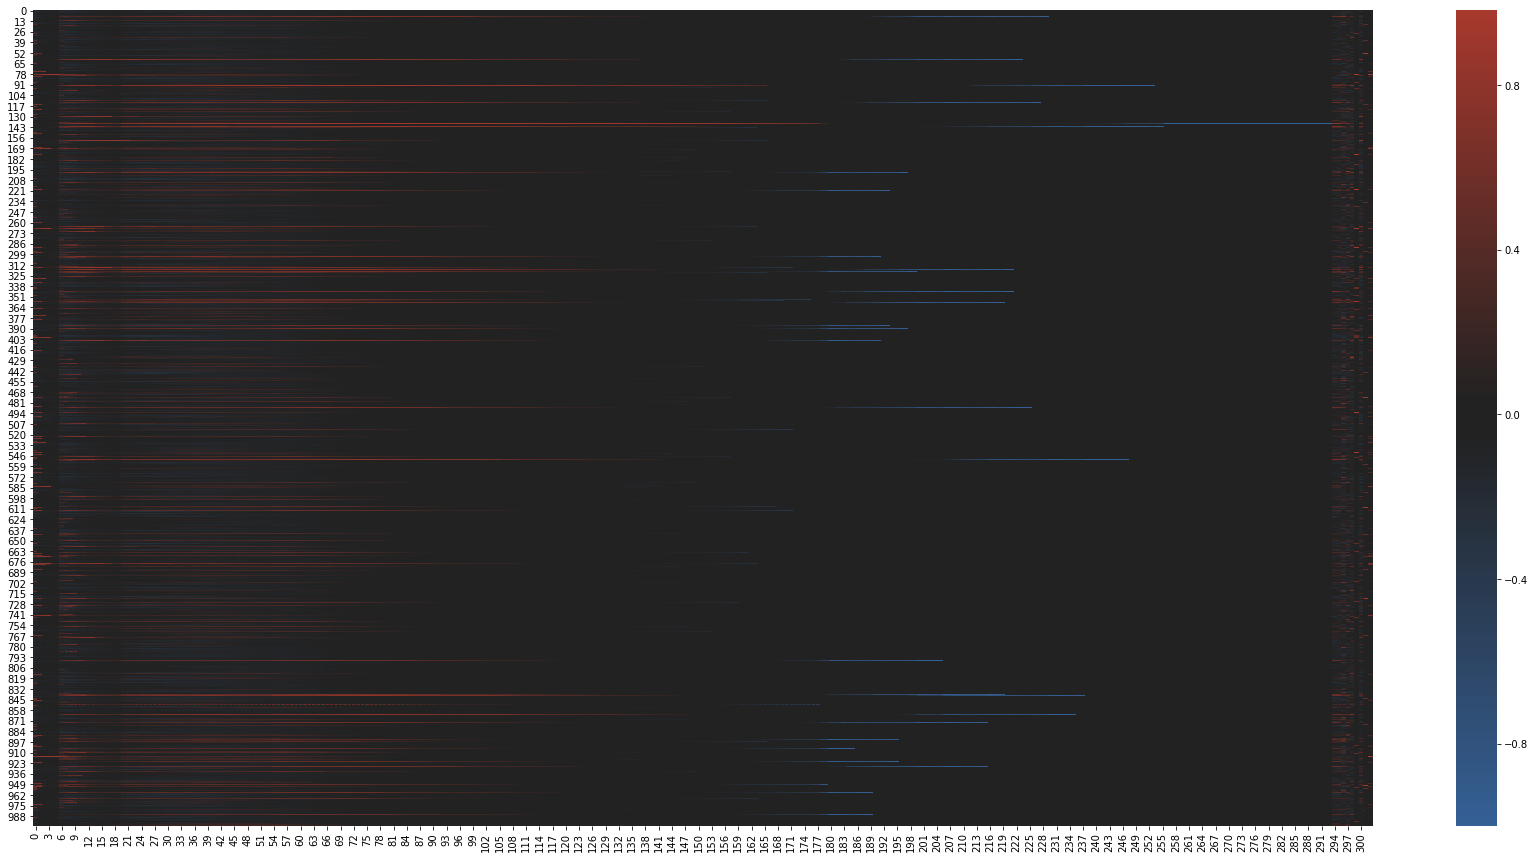

In [6]:
dif = np.max(train_features, axis=0) - np.min(train_features, axis=0)
np.place(dif, dif == 0., [1.])
mean = np.mean(train_features, axis=0)
scaled = (train_features.copy() - mean) / dif
plt.figure(figsize=(30,15))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=1000, center="dark")
sns.heatmap(scaled, cmap=cmap)
plt.savefig('train_features.png')

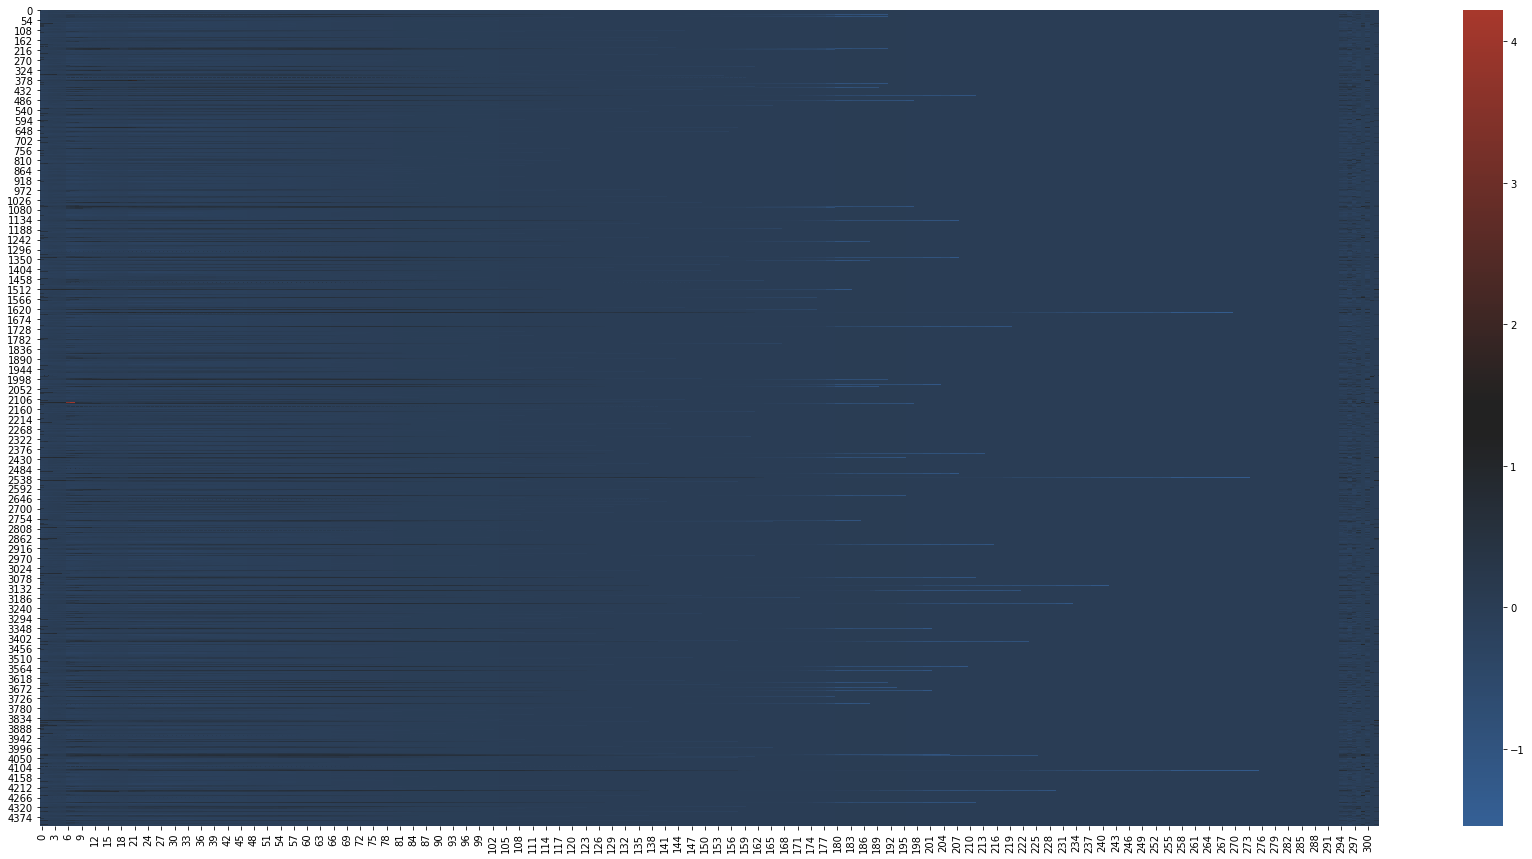

In [7]:
scaled = (test_features.copy() - mean) / dif
plt.figure(figsize=(30,15))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=1000, center="dark")
sns.heatmap(scaled, cmap=cmap)
plt.savefig('test_features.png')

We can make some parallel coordinate plots using pandas to get a slightly better idea of how the feature vectors look. Initially, we set up the dataframe containing the training data.

In [8]:
tf = train_features.copy()
td = np.reshape(train_targets.copy(), (len(train_targets), 1))
train_data = np.concatenate((tf, td), axis=1)

columns = ['f{}'.format(i) for i in range(np.shape(train_features)[1])]
columns += ['target']
index = range(np.shape(train_features)[0])
df = pd.DataFrame(train_data, index=index, columns=columns)

We can then define the plotting function. This just takes the dataframe object.

In [9]:
cmap = cm.get_cmap('Spectral')

def parallel_plot(data):
    plt.figure(figsize=(50,25))
    ax = parallel_coordinates(
        data, 'target', colormap=cmap, axvlines=False)

    plt.legend().set_visible(False)
    plt.grid(False)

    ax.xaxis.set_ticks_position('none')
    for label in ax.get_xticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(0)
    for label in ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(30)
    axis_font = {'fontname':'Arial', 'size':'35'}
    plt.ylabel("Numeric Representation", **axis_font)
    plt.xlabel("Fingerprint", **axis_font)

We can then plot the original unscaled data.

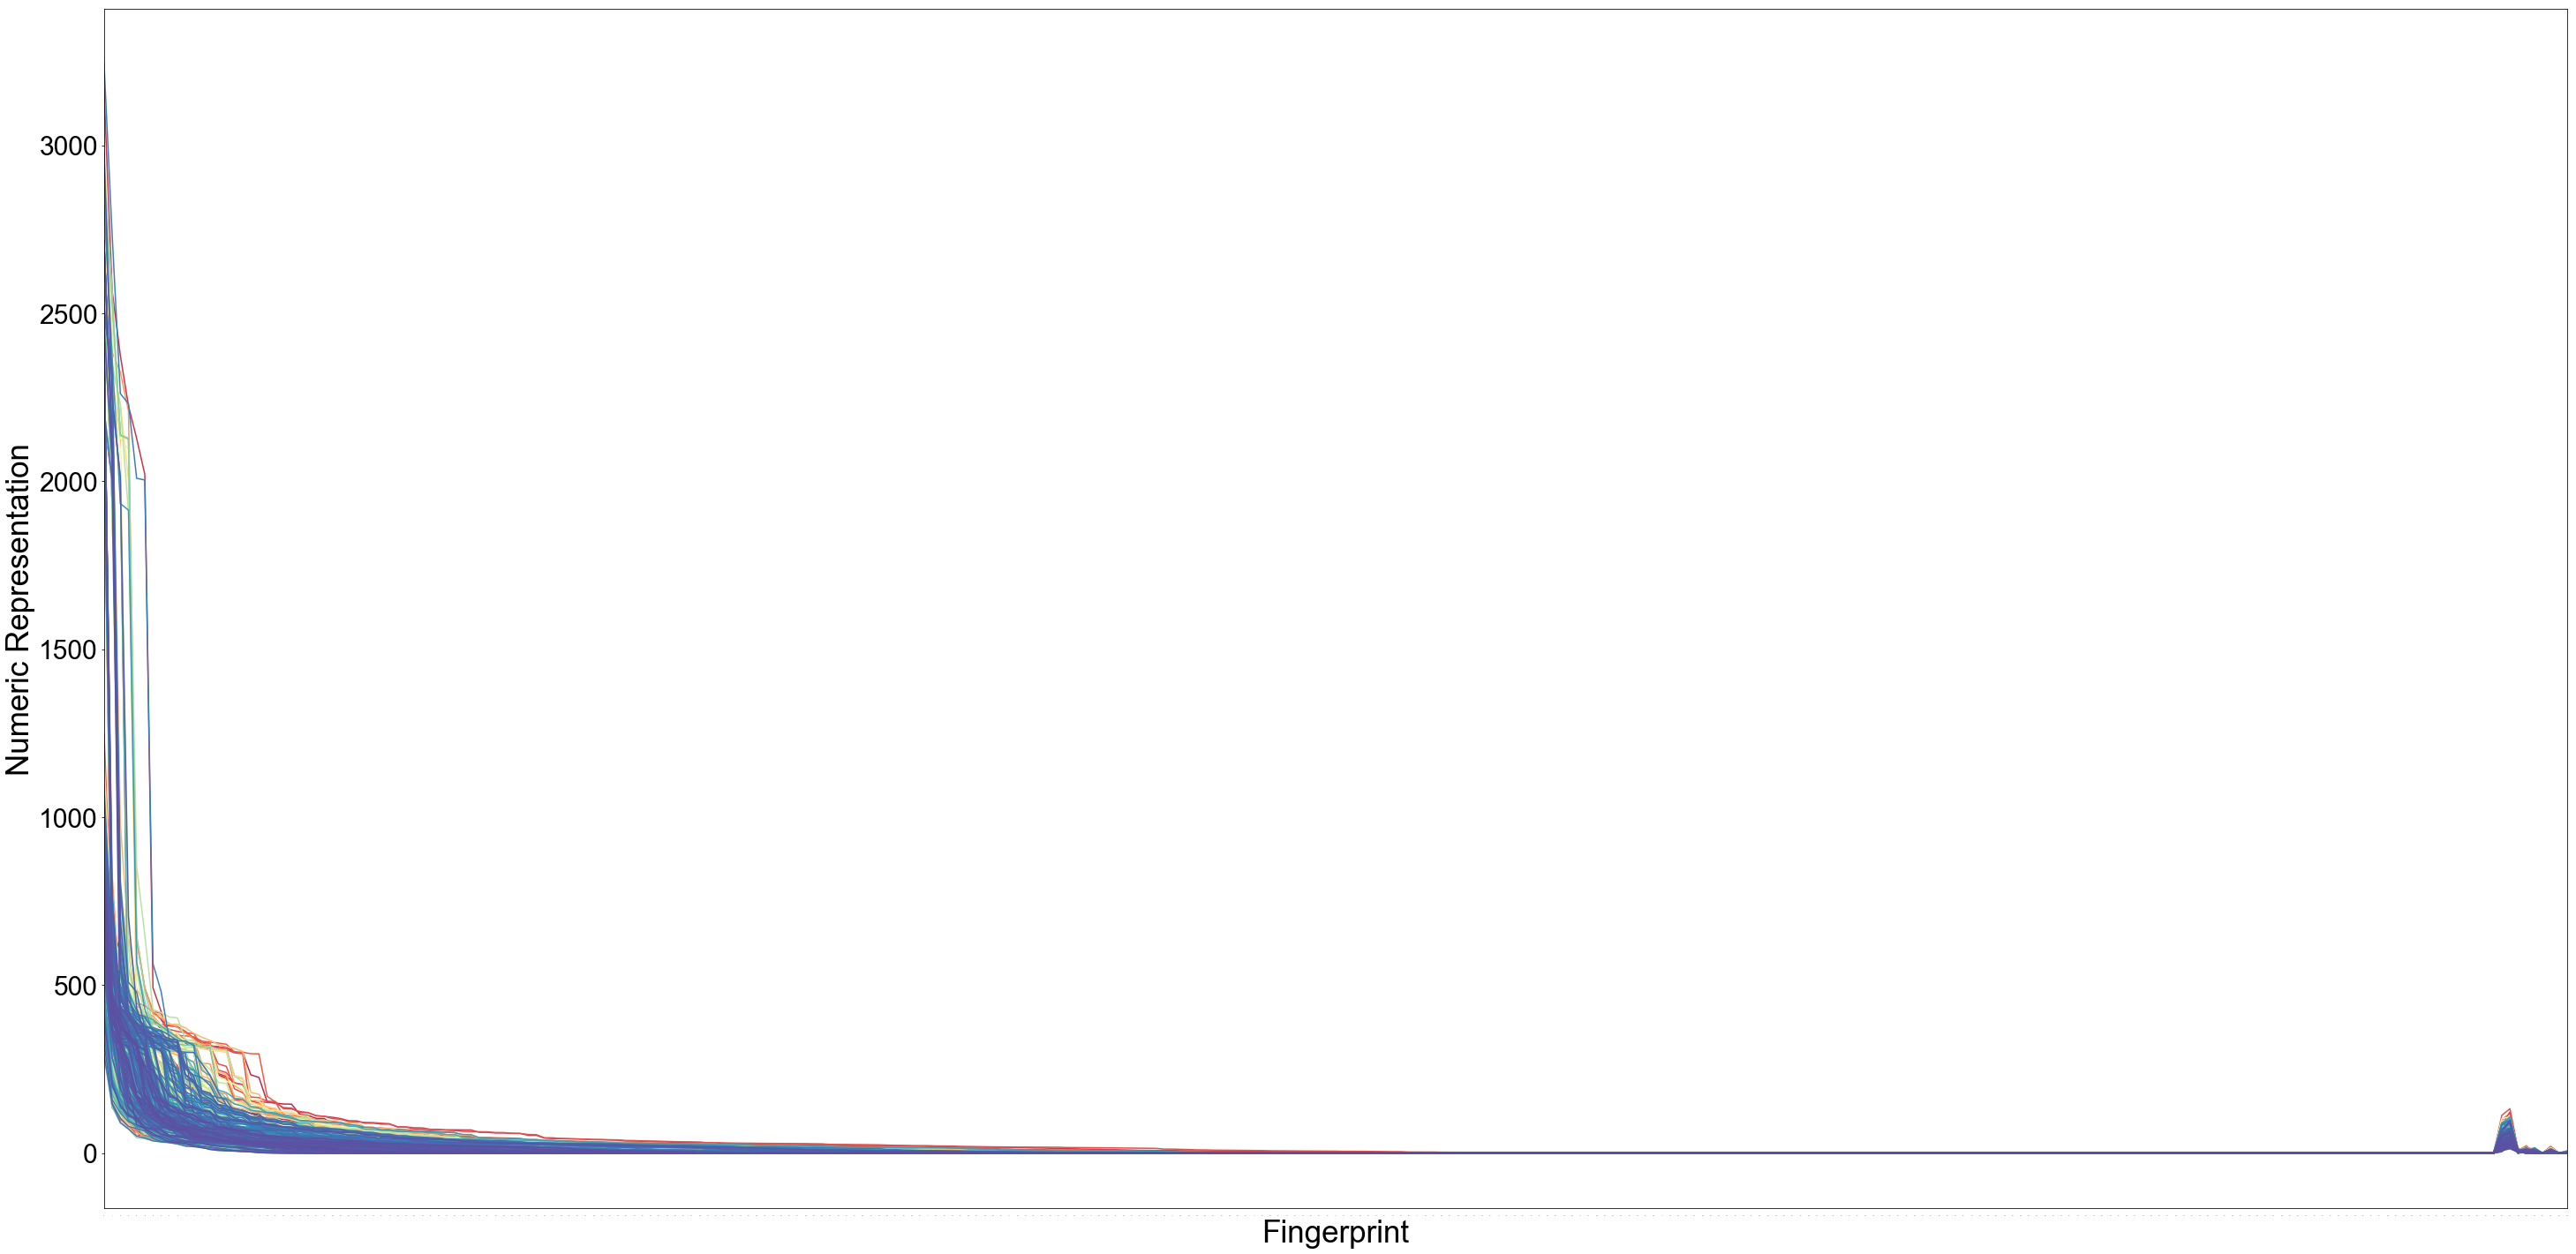

In [10]:
parallel_plot(df)
plt.savefig('orig.png')

The normalized data.

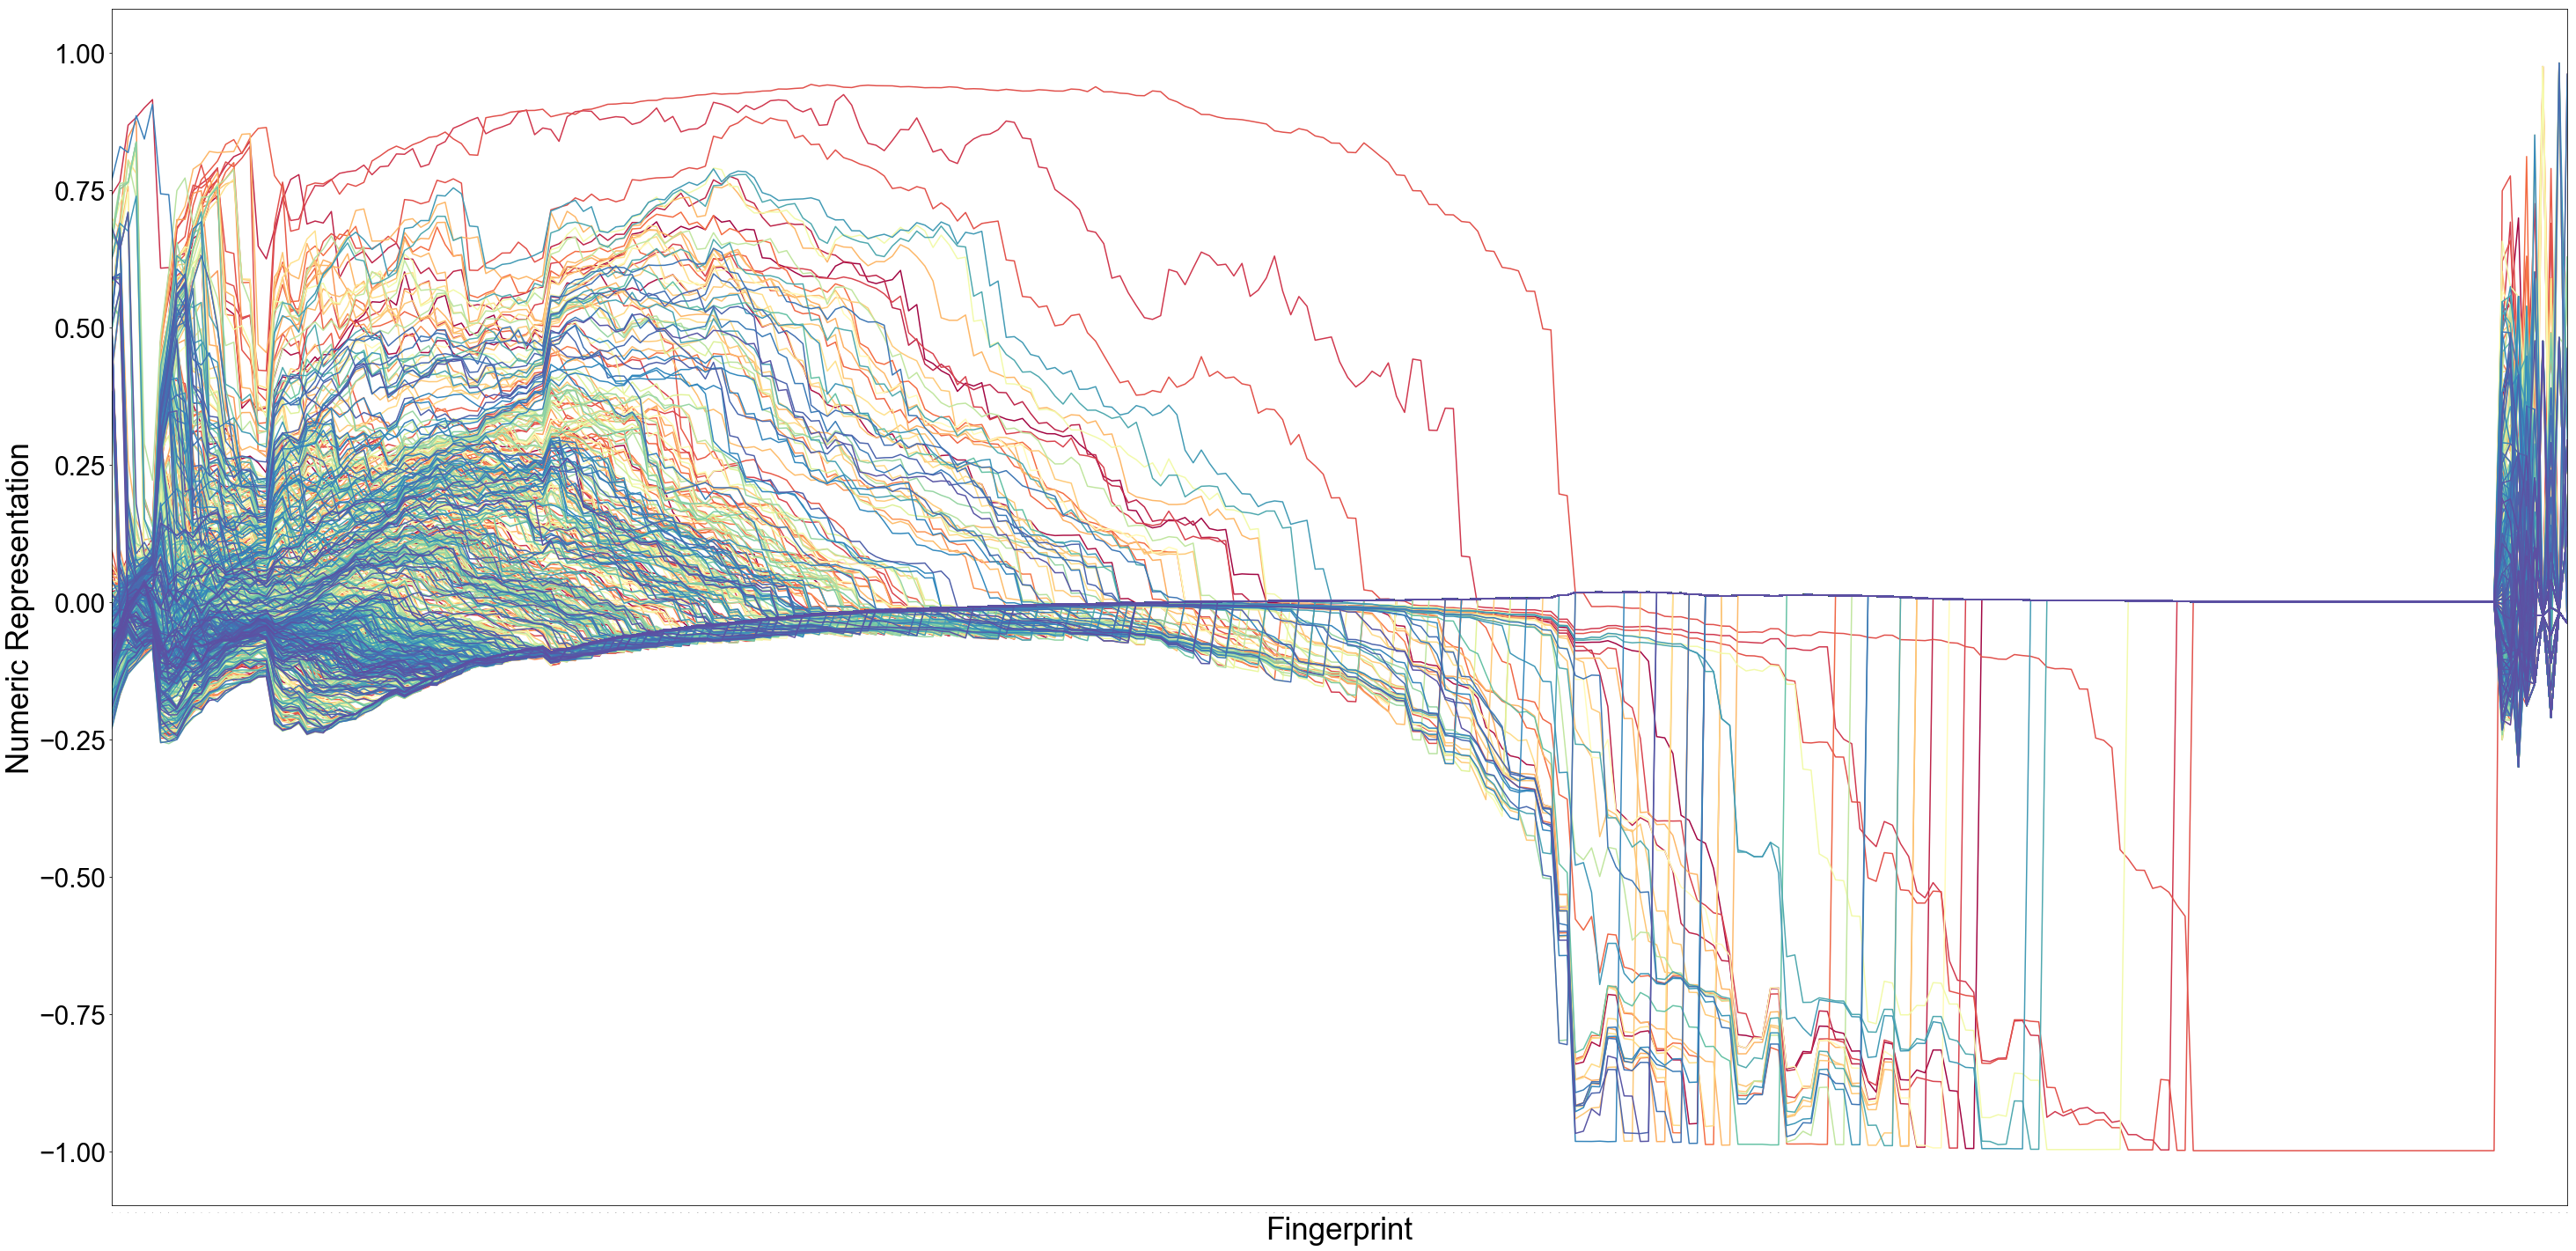

In [11]:
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm.fillna(0.)
parallel_plot(df_norm)
plt.savefig('norm.png')

And the standardized data.

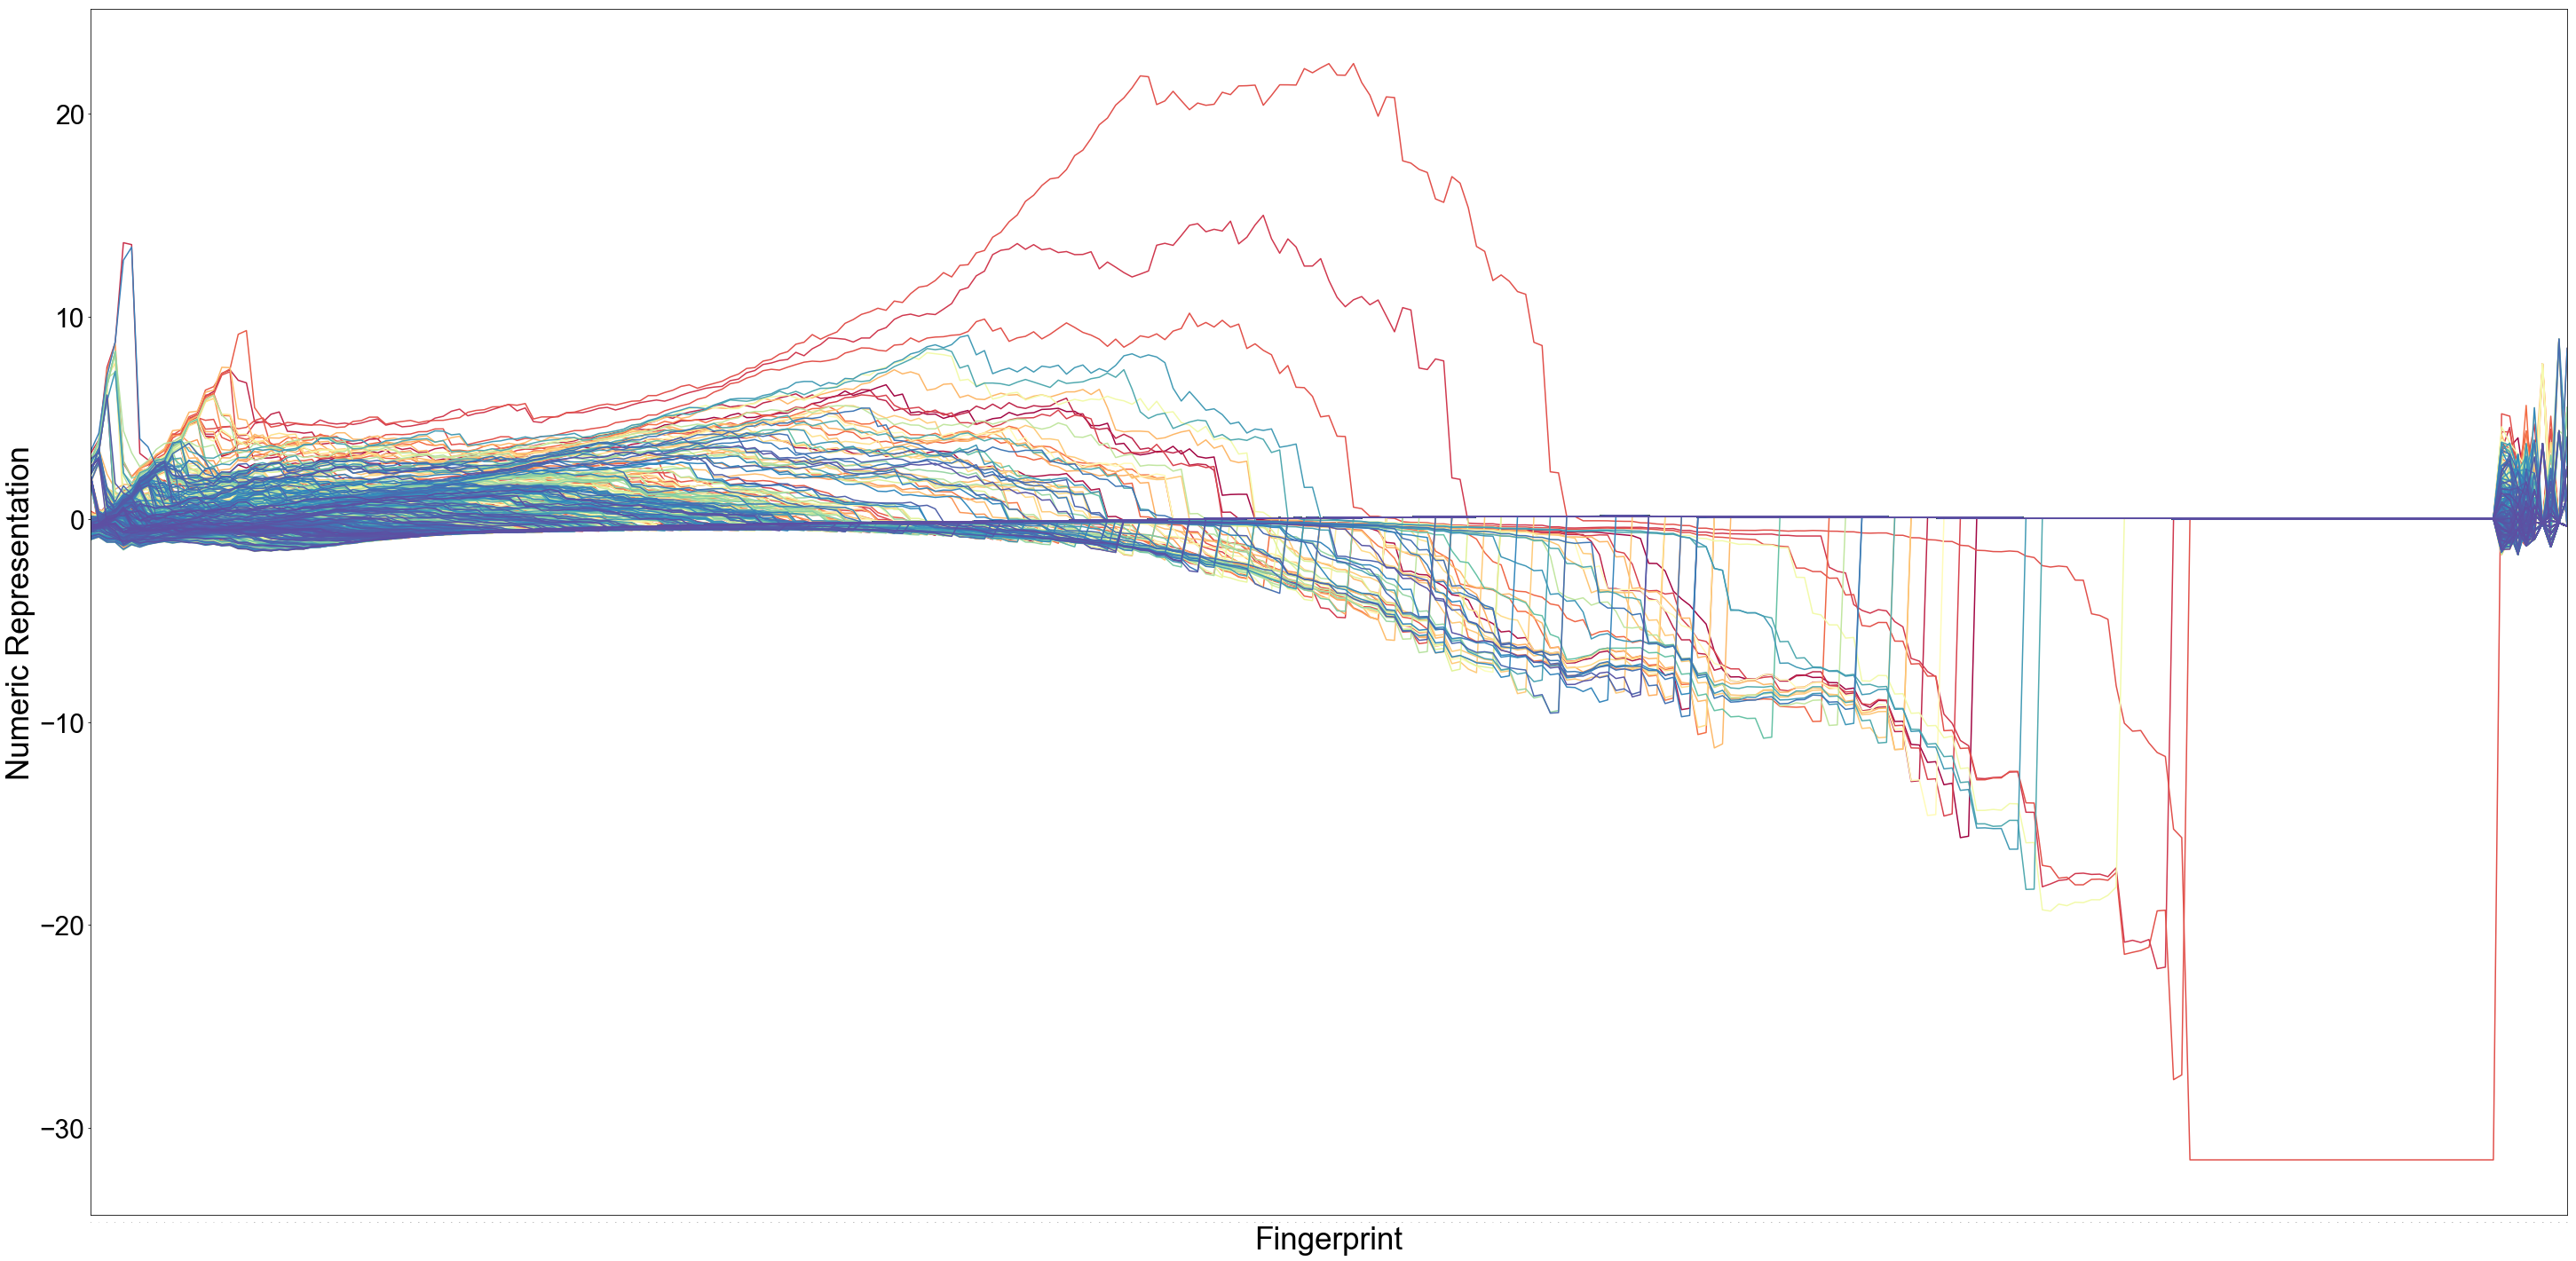

In [12]:
df_std = (df - df.mean()) / df.std()
df_std.fillna(0.)
parallel_plot(df_std)
plt.savefig('std.png')

## Predictions <a name="predictions"></a>
[(Back to top)](#head)

We can now try predictions with ridge regression to start. This clearly performs very well with this data. Based on these results, it is unlikely that you would consider moving to more complex models.

/mnt/c/Users/raul_desktop/github/Catlearn/catlearn/regression/ridge_regression.py:433: RuntimeWarning: divide by zero encountered in power
  np.dot(Y_.T, P), np.diag(np.diag(P)**-2)), P), Y_)


63422.51844262362


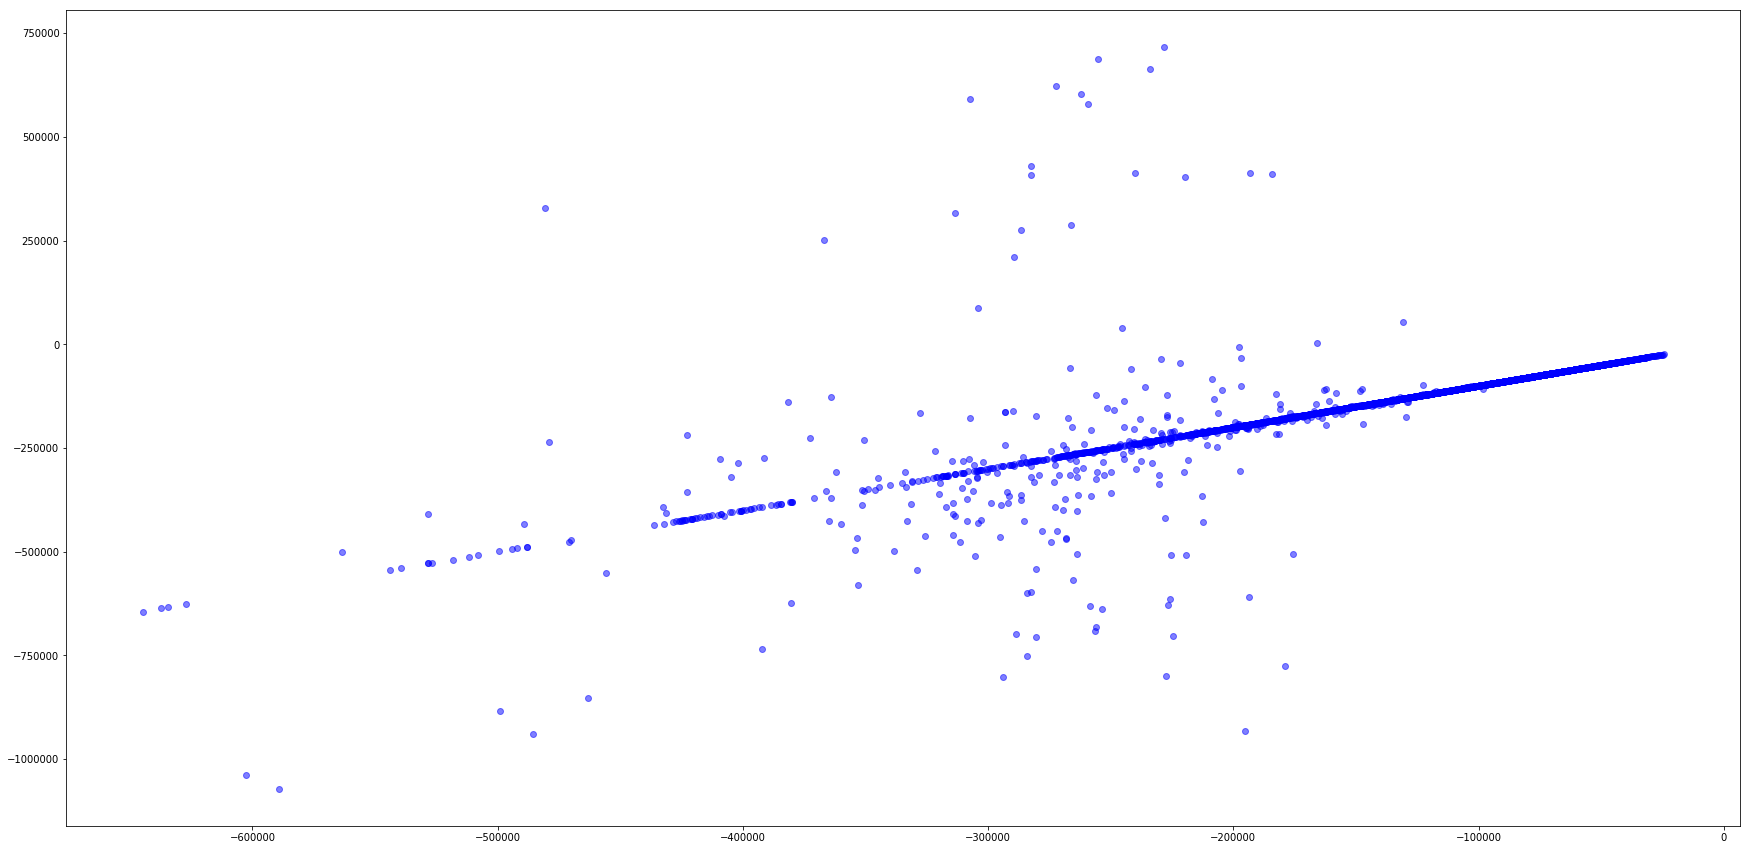

In [13]:
# Set up the ridge regression function.
rr = RidgeRegression(W2=None, Vh=None, cv='loocv')
b = rr.find_optimal_regularization(X=train_features, Y=train_targets)
coef = rr.RR(X=train_features, Y=train_targets, omega2=b)[0]

# Test the model.
sumd = 0.
err = []
pred = []
for tf, tt in zip(test_features, test_targets):
    p = np.dot(coef, tf)
    pred.append(p)
    sumd += (p - tt) ** 2
    e = ((p - tt) ** 2) ** 0.5
    err.append(e)
error = (sumd / len(test_features)) ** 0.5

print(error)

plt.figure(figsize=(30, 15))
plt.plot(test_targets, pred, 'o', c='b', alpha=0.5)
plt.savefig('ridge_regression.png')

However, for the purposes of this tutorial, we then train a Gaussian processes regression model to test. In this case, we set up a kernel dictionary that has both the squared exponential and linear kernels. The initial parameters defined in the kernel aren't so important at this stage as they are all optimized when the model is trained.

1126.777158653352


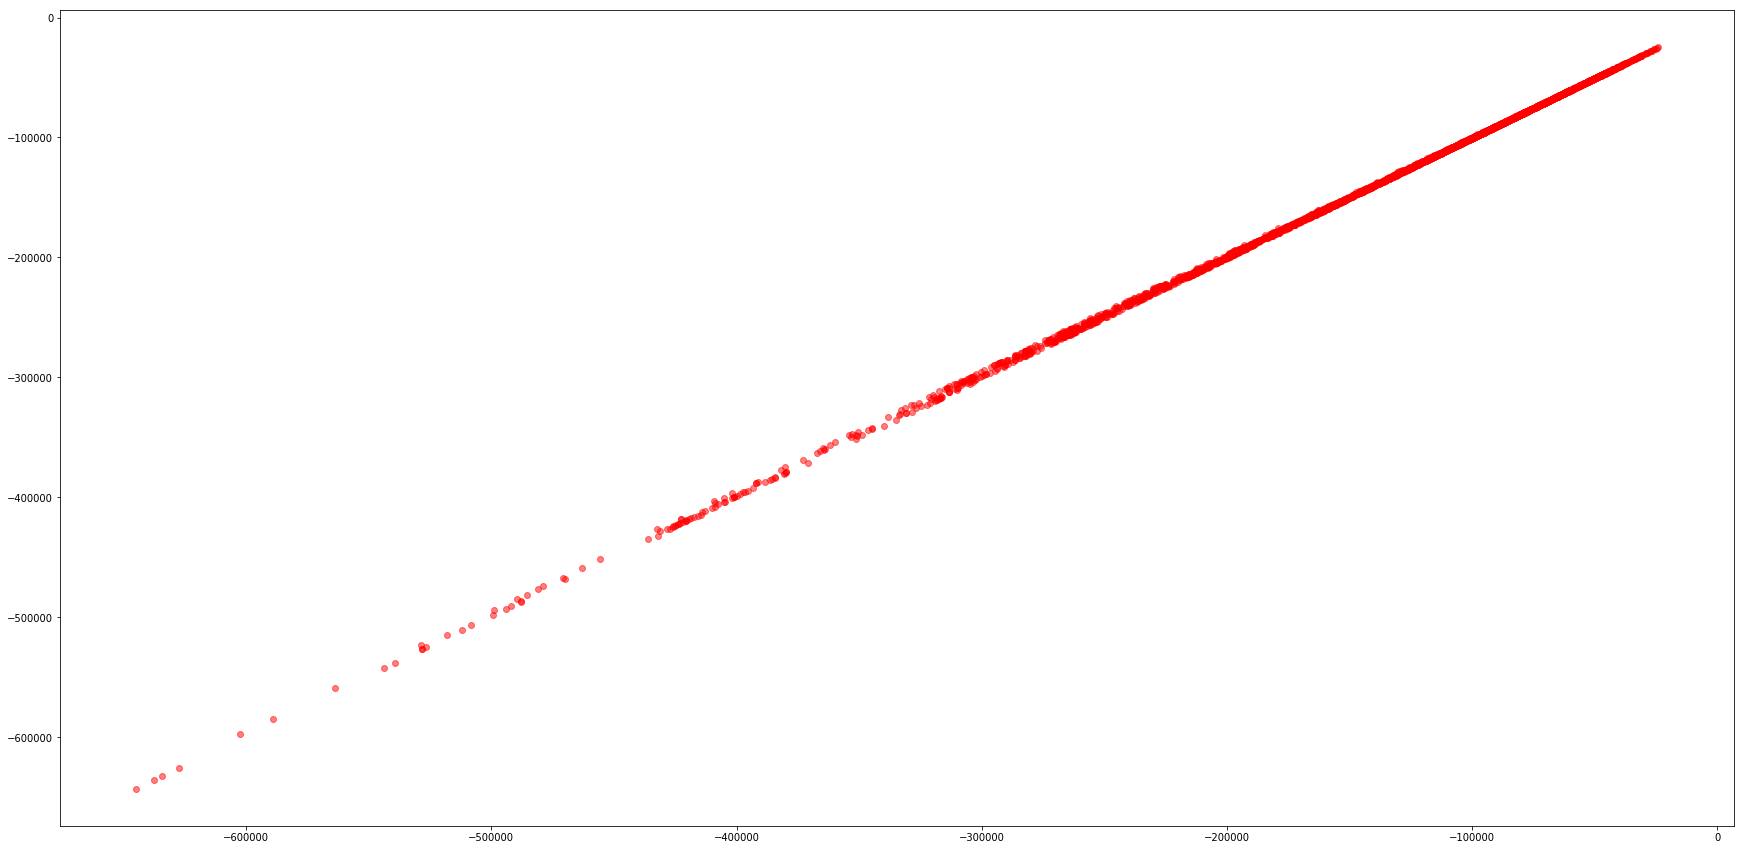

In [14]:
kdict = [
    {
        'type': 'gaussian', 'width': 1., 'scaling': 1., 'dimension': 'single'},
    {
        'type': 'linear', 'scaling': 1.},
    ]
gp = GaussianProcess(train_fp=train_features, train_target=train_targets,
                     kernel_list=kdict, regularization=1e-2,
                     optimize_hyperparameters=True, scale_data=True)

pred = gp.predict(test_fp=test_features)

error = get_error(pred['prediction'],
                  test_targets)['rmse_average']

print(error)

plt.figure(figsize=(30, 15))
plt.plot(test_targets, pred['prediction'], 'o', c='r', alpha=0.5)
plt.savefig('gaussian_process.png')

Here we see that the Gaussian process performs slightly worse than the simple ridge regression model. This is to be expected when we are trying to model linear data with a non-linear model. However, the inclusion of the linear kernel results in a good prediction error. If the squared exponential kernel were to be removed from the above example, the resulting model would be the same as the ridge regression model, just trained with the Gaussian process.

## Cross-validation <a name="cross-validation"></a>
[(Back to top)](#head)

We can use the hierarchy cross-validation module to investigate how the model performs with different data sizes. In the following, we set up a prediction function. As the ridge regression function performs well, we just redefine this. The prediction function should take in the training and testing data and return a dictionary in the form `{'result': list, 'size': list}`.

In [15]:
def rr_predict(train_features, train_targets, test_features, test_targets):
    """Function to perform the RR predictions."""
    data = {}

    # Set up the ridge regression function.
    rr = RidgeRegression(W2=None, Vh=None, cv='loocv')
    b = rr.find_optimal_regularization(X=train_features, Y=train_targets)
    coef = rr.RR(X=train_features, Y=train_targets, omega2=b)[0]

    # Test the model.
    sumd = 0.
    err = []
    for tf, tt in zip(test_features, test_targets):
        p = np.dot(coef, tf)
        sumd += (p - tt) ** 2
        e = ((p - tt) ** 2) ** 0.5
        err.append(e)
    error = (sumd / len(test_features)) ** 0.5

    data['result'] = error
    data['size'] = len(train_targets)

    return data

We then run the cv and display the resulting learning curve.

In [ ]:
features = np.concatenate((train_features, test_features), axis=0)

# Initialize hierarchy cv class.
hv = Hierarchy(db_name='test.sqlite', file_name='hierarchy')
# Convert features and targets to simple db format.
hv.todb(features=features, targets=targets)
# Split the data into subsets.
ind = hv.split_index(min_split=200, max_split=5000)

# Make the predictions for each subset.
pred = hv.split_predict(index_split=ind, predict=rr_predict)

# Get mean error at each data size.
means, meane = hv.transform_output(pred)

# Plot the results.
plt.figure(figsize=(30, 15))
plt.plot(pred[1], pred[0], 'o', c='g', alpha=0.5)
plt.plot(means, meane, '-', alpha=0.9, c='black')
plt.savefig('learning_curve.png')

Finally, the output is removed.

In [19]:
os.remove('hierarchy.pickle')
os.remove('test.sqlite')

# Removing plots
os.remove('gaussian_process.png')
os.remove('learning_curve.png')
os.remove('norm.png')
os.remove('orig.png')
os.remove('ridge_regression.png')
os.remove('std.png')
os.remove('test_features.png')
os.remove('train_features.png')